<a href="https://colab.research.google.com/github/kappandrew2/DataPreProcessing/blob/main/MarketResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Purpose

Utilize historical value and time attributes to predict the next day's gain or loss value

!Dataset Notes: The dataset for this data solution must come from the following web sit and contain a large historical sample of data. For example:

Begin Date = 12/01/2007 (Be mindful that the last 35 periods (in this case, days) will get chopped off of the bottom of the dataset during data preprocessing)

End Date = Today's current value (to be run an hour before market close)

Ticker = SPY

Train Set = all data except last 60 periods (rows)

Prediction Set = all data from -90 periods (days) to current

https://www.wsj.com/market-data/quotes/index/SPX/historical-prices


In [437]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from datetime import date, datetime, timedelta
from pandas._libs.tslibs.timestamps import Timestamp

#Connect to drive and import data set

Using google drive

Importing historical prices for ticker "SPY"

In [438]:
#Create CSV from data export
#https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesSPY.csv')

print(dataset)

Mounted at /content/drive
          Date     Open    High     Low     Close     Volume
0     08/02/21  440.340  440.93  437.21  437.5900   58497300
1     07/30/21  437.910  440.06  437.77  438.5100   68951203
2     07/29/21  439.815  441.80  439.81  440.6500   47435340
3     07/28/21  439.680  440.30  437.31  438.8300   52472359
4     07/27/21  439.910  439.94  435.99  439.0100   67397133
...        ...      ...     ...     ...       ...        ...
1400  01/08/16  195.190  195.85  191.58  191.9230  209817203
1401  01/07/16  195.330  197.44  193.59  194.0500  213436094
1402  01/06/16  198.340  200.06  197.60  198.8200  152112609
1403  01/05/16  201.400  201.90  200.05  201.3600  110845797
1404  01/04/16  200.490  201.03  198.59  201.0192  222353500

[1405 rows x 6 columns]


#Modifiy dataset Content and Headers

Remove contents not required for this exercise

Renaming columns to remove leading white space

Narrowing the dataset can be done via drop or select, both options are available (comment out the one not in use)

In [439]:
dataset.rename({' Close': 'Close'}, axis=1, inplace = True)
dataset = dataset[['Close', 'Date']]
#dataset = dataset.drop([' Open', ' High', ' Low', ' Volume'], axis = 1)

#Dataset information validation

Validate date frame, column contents and data types

In [440]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Close   1405 non-null   float64       
 1   Date    1405 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.1 KB


#Change indext to date (for troublshooting)

Moving date to the index assists in visually validating processes are working correctly

!Note: This should be "off" except when troublshooting

In [441]:
#dataset['Date_Index'] = dataset['Date']
#dataset.set_index('Date_Index', inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Close   1405 non-null   float64       
 1   Date    1405 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.1 KB


#Create time attributes

Time attributes will change date from a continous variable into discrete (a numeric categorical value)

In [442]:
dataset['DOW'] = dataset['Date'].dt.dayofweek
dataset['DOY'] = dataset['Date'].dt.dayofyear
dataset['Week'] = dataset['Date'].dt.week
dataset['Month'] = dataset['Date'].dt.month
dataset['Quarter'] = dataset['Date'].dt.quarter

dataset.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Close             float64
Date       datetime64[ns]
DOW                 int64
DOY                 int64
Week                int64
Month               int64
Quarter             int64
dtype: object

#Create skip-day gain loss values (and dependant variable #1)

!Note: gain-loss-0 will ultimately end up being the dependant variable but also an independant variable (we will create a new column later and shift it down a row)

1) Calculate the first day's gain loss by subtracting day -1 from day 0

2) Calculate the second day's gain loss by subtracting day -2 from day 0

3) Calculate the third day's gain loss by subtracting day -n from day 0

!Note: This should be turned into a loop using i=n where n = the rows to be processed (now many previous rows)




In [443]:
dataset['gain_loss-0'] = dataset['Close'].diff(-1)
dataset['gain_loss-1'] = dataset['Close'].diff(-2)
#dataset['gain_loss-1'] = dataset['gain_loss-1'].shift(periods=-1, fill_value=0) #Removed these to experiment 
#with switching around the dependant variable rather than the independant variable
dataset['gain_loss-2'] = dataset['Close'].diff(-3) 
#dataset['gain_loss-2'] = dataset['gain_loss-2'].shift(periods=-1, fill_value=0)
dataset['gain_loss-3'] = dataset['Close'].diff(-4) 
#dataset['gain_loss-3'] = dataset['gain_loss-3'].shift(periods=-1, fill_value=0)
dataset['gain_loss-4'] = dataset['Close'].diff(-5) 
#dataset['gain_loss-4'] = dataset['gain_loss-4'].shift(periods=-1, fill_value=0)

print(dataset)
#dataset.dtypes

         Close       Date  DOW  ...  gain_loss-2  gain_loss-3  gain_loss-4
0     437.5900 2021-08-02    0  ...      -1.2400      -1.4200        -3.43
1     438.5100 2021-07-30    4  ...      -0.5000      -2.5100        -1.43
2     440.6500 2021-07-29    3  ...      -0.3700       0.7100         5.19
3     438.8300 2021-07-28    2  ...      -1.1100       3.3700         4.28
4     439.0100 2021-07-27    1  ...       3.5500       4.4600         7.95
...        ...        ...  ...  ...          ...          ...          ...
1400  191.9230 2016-01-08    4  ...      -9.4370      -9.0962          NaN
1401  194.0500 2016-01-07    3  ...      -6.9692          NaN          NaN
1402  198.8200 2016-01-06    2  ...          NaN          NaN          NaN
1403  201.3600 2016-01-05    1  ...          NaN          NaN          NaN
1404  201.0192 2016-01-04    0  ...          NaN          NaN          NaN

[1405 rows x 12 columns]


#Create binary version of skip-day gain loss values (and dependant variable #2)

!Note: gain-loss-0b will ultimately end up being the dependant variable but also an independant variable (we will create a new column later and shift it down a row)

This process changes all gain loss continuous variables into a binary-descrete (dichotomous) variables

!Note - This process should be converted into the previous process when that process is converted into a loop

In [444]:
dataset['gain_loss-0b'] = np.where(dataset['gain_loss-0'] > 0, 1, 0)
dataset['gain_loss-1b'] = np.where(dataset['gain_loss-1'] > 0, 1, 0)
dataset['gain_loss-2b'] = np.where(dataset['gain_loss-2'] > 0, 1, 0)
dataset['gain_loss-3b'] = np.where(dataset['gain_loss-3'] > 0, 1, 0)
dataset['gain_loss-4b'] = np.where(dataset['gain_loss-4'] > 0, 1, 0)

dataset.dtypes

Close                  float64
Date            datetime64[ns]
DOW                      int64
DOY                      int64
Week                     int64
Month                    int64
Quarter                  int64
gain_loss-0            float64
gain_loss-1            float64
gain_loss-2            float64
gain_loss-3            float64
gain_loss-4            float64
gain_loss-0b             int64
gain_loss-1b             int64
gain_loss-2b             int64
gain_loss-3b             int64
gain_loss-4b             int64
dtype: object

#Aggregate the binary skip-day gain loss values

This creates a true categorical value from the binary descrete values.

The theory is that, having binary values for each period (sparce matrix) and an aggregate (categorical), the values will work together to increase the value of this data

!Note = This process should be indluded in the loop mentioned in notes from the above process (future modifications to the data pre-processing procedures)

In [445]:
dataset['gain_loss-total_b'] = dataset['gain_loss-0b'] + dataset['gain_loss-1b'] + dataset['gain_loss-2b'] + dataset['gain_loss-3b'] + dataset['gain_loss-4b']

dataset.head(-1)

,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b
0,437.590,2021-08-02,0,214,31,8,3,-0.9200,-3.0600,-1.2400,-1.4200,-3.4300,0,0,0,0,0,0
1,438.510,2021-07-30,4,211,30,7,3,-2.1400,-0.3200,-0.5000,-2.5100,-1.4300,0,0,0,0,0,0
2,440.650,2021-07-29,3,210,30,7,3,1.8200,1.6400,-0.3700,0.7100,5.1900,1,1,0,1,1,4
3,438.830,2021-07-28,2,209,30,7,3,-0.1800,-2.1900,-1.1100,3.3700,4.2800,0,0,0,1,1,2
4,439.010,2021-07-27,1,208,30,7,3,-2.0100,-0.9300,3.5500,4.4600,7.9500,0,0,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,192.110,2016-01-11,0,11,2,1,1,0.1870,-1.9400,-6.7100,-9.2500,-8.9092,1,0,0,0,0,1
1400,191.923,2016-01-08,4,8,1,1,1,-2.1270,-6.8970,-9.4370,-9.0962,NaN,0,0,0,0,0,0
1401,194.050,2016-01-07,3,7,1,1,1,-4.7700,-7.3100,-6.9692,NaN,NaN,0,0,0,0,0,0
1402,198.820,2016-01-06,2,6,1,1,1,-2.5400,-2.1992,NaN,NaN,NaN,0,0,0,0,0,0


#Create daily gain loss and denormalize values

1) Calculate the first day's gain loss by subtracting day -1 from day 0

2) Calculate the second day's gain loss by subtracting day -2 from day -1

3) Calculate the third day's gain loss by subtracting day -n from day -n+1

This process creates a new column and removes the top rows in accordance with the desired "lookback" period - shift over 1 and lift by 1, shift over 2 and lift by 2, shift over n and lift by n

!Note: This should be turned into a loop using i=n where n = the rows to be processed (now many previous rows)


In [446]:
dataset['prior_day-0'] = dataset['gain_loss-0']
#dataset['prior_day-1'] = dataset['prior_day-1'].shift(periods=-1, fill_value=0)#Removed this to experiment 
#with switching around the dependant variable rather than the independant variable
dataset['prior_day-1'] = dataset['gain_loss-0']
dataset['prior_day-1'] = dataset['prior_day-1'].shift(periods=-1, fill_value=0)
dataset['prior_day-2'] = dataset['gain_loss-0']
dataset['prior_day-2'] = dataset['prior_day-2'].shift(periods=-2, fill_value=0)
dataset['prior_day-3'] = dataset['gain_loss-0']
dataset['prior_day-3'] = dataset['prior_day-3'].shift(periods=-3, fill_value=0)
dataset['prior_day-4'] = dataset['gain_loss-0']
dataset['prior_day-4'] = dataset['prior_day-4'].shift(periods=-4, fill_value=0)
dataset.head()

,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4
0,437.59,2021-08-02,0,214,31,8,3,-0.92,-3.06,-1.24,-1.42,-3.43,0,0,0,0,0,0,-0.92,-2.14,1.82,-0.18,-2.01
1,438.51,2021-07-30,4,211,30,7,3,-2.14,-0.32,-0.50,-2.51,-1.43,0,0,0,0,0,0,-2.14,1.82,-0.18,-2.01,1.08
2,440.65,2021-07-29,3,210,30,7,3,1.82,1.64,-0.37,0.71,5.19,1,1,0,1,1,4,1.82,-0.18,-2.01,1.08,4.48
3,438.83,2021-07-28,2,209,30,7,3,-0.18,-2.19,-1.11,3.37,4.28,0,0,0,1,1,2,-0.18,-2.01,1.08,4.48,0.91
4,439.01,2021-07-27,1,208,30,7,3,-2.01,-0.93,3.55,4.46,7.95,0,0,1,1,1,3,-2.01,1.08,4.48,0.91,3.49


#Create binary version of daily gain loss values

This process changes all gain loss continuous variables into a binary-descrete (dichotomous) variables

!Note - This process should be converted into the previous process when that process is converted into a loop

In [447]:
dataset['prior_day-0b'] = np.where(dataset['prior_day-0'] > 0, 1, 0)
dataset['prior_day-1b'] = np.where(dataset['prior_day-1'] > 0, 1, 0)
dataset['prior_day-2b'] = np.where(dataset['prior_day-2'] > 0, 1, 0)
dataset['prior_day-3b'] = np.where(dataset['prior_day-3'] > 0, 1, 0)
dataset['prior_day-4b'] = np.where(dataset['prior_day-4'] > 0, 1, 0)
dataset.head()

,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4,prior_day-0b,prior_day-1b,prior_day-2b,prior_day-3b,prior_day-4b
0,437.59,2021-08-02,0,214,31,8,3,-0.92,-3.06,-1.24,-1.42,-3.43,0,0,0,0,0,0,-0.92,-2.14,1.82,-0.18,-2.01,0,0,1,0,0
1,438.51,2021-07-30,4,211,30,7,3,-2.14,-0.32,-0.50,-2.51,-1.43,0,0,0,0,0,0,-2.14,1.82,-0.18,-2.01,1.08,0,1,0,0,1
2,440.65,2021-07-29,3,210,30,7,3,1.82,1.64,-0.37,0.71,5.19,1,1,0,1,1,4,1.82,-0.18,-2.01,1.08,4.48,1,0,0,1,1
3,438.83,2021-07-28,2,209,30,7,3,-0.18,-2.19,-1.11,3.37,4.28,0,0,0,1,1,2,-0.18,-2.01,1.08,4.48,0.91,0,0,1,1,1
4,439.01,2021-07-27,1,208,30,7,3,-2.01,-0.93,3.55,4.46,7.95,0,0,1,1,1,3,-2.01,1.08,4.48,0.91,3.49,0,1,1,1,1


#Aggregate the binary daily gain loss values

This creates a true categorical value from the binary descrete values.

The theory is that, having binary values for each period (sparce matrix) and an aggregate (categorical), the values will work together to increase the value of this data

!Note = This process should be indluded in the loop mentioned in notes from the above process (future modifications to the data pre-processing procedures)

In [448]:
dataset['prior_day-total_b'] = dataset['prior_day-0b'] + dataset['prior_day-1b'] + dataset['prior_day-2b'] + dataset['prior_day-3b'] + dataset['prior_day-4b'] 
dataset.head(5)

,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4,prior_day-0b,prior_day-1b,prior_day-2b,prior_day-3b,prior_day-4b,prior_day-total_b
0,437.59,2021-08-02,0,214,31,8,3,-0.92,-3.06,-1.24,-1.42,-3.43,0,0,0,0,0,0,-0.92,-2.14,1.82,-0.18,-2.01,0,0,1,0,0,1
1,438.51,2021-07-30,4,211,30,7,3,-2.14,-0.32,-0.50,-2.51,-1.43,0,0,0,0,0,0,-2.14,1.82,-0.18,-2.01,1.08,0,1,0,0,1,2
2,440.65,2021-07-29,3,210,30,7,3,1.82,1.64,-0.37,0.71,5.19,1,1,0,1,1,4,1.82,-0.18,-2.01,1.08,4.48,1,0,0,1,1,3
3,438.83,2021-07-28,2,209,30,7,3,-0.18,-2.19,-1.11,3.37,4.28,0,0,0,1,1,2,-0.18,-2.01,1.08,4.48,0.91,0,0,1,1,1,3
4,439.01,2021-07-27,1,208,30,7,3,-2.01,-0.93,3.55,4.46,7.95,0,0,1,1,1,3,-2.01,1.08,4.48,0.91,3.49,0,1,1,1,1,4


#Creating Rolling mean attribute values

Rolling mean values are based on daily gain loss and represent the trending direction of the prior n mean values (5, 10, 15, n, row mean values)

the rolling mean works from the top row down - for exampple the mean of row 1 and 2 would appear on row 2. We need the mean of row 1 and 2 to land on row 1. This requires us to reverse the index of each desired mean column. The process to do this creates pandas value lists

!Note: this process can convert into a loop  where n = list of n mean values (as described in the description above)

In [449]:
#Rolling averages based on prior day gain loss
rolling_prior_day = dataset['prior_day-0']

rolling_prior_day_5 = rolling_prior_day[::-1].rolling(5).mean()[::-1]
rolling_prior_day_10 = rolling_prior_day[::-1].rolling(10).mean()[::-1]
rolling_prior_day_15 = rolling_prior_day[::-1].rolling(15).mean()[::-1]
rolling_prior_day_20 = rolling_prior_day[::-1].rolling(20).mean()[::-1]
rolling_prior_day_25 = rolling_prior_day[::-1].rolling(25).mean()[::-1]
rolling_prior_day_30 = rolling_prior_day[::-1].rolling(30).mean()[::-1]

print(rolling_prior_day_10)

0       1.262
1       0.717
2       0.590
3       0.259
4       0.342
        ...  
1400      NaN
1401      NaN
1402      NaN
1403      NaN
1404      NaN
Name: prior_day-0, Length: 1405, dtype: float64


#Create close variance variable and binary

Close variance uses a rolling averages of n days (Close attribute) minus the row's Close value. This indicates when the market is falling below a rolling average. 

The binary is calculated based on 1 = >0 and 0<0

In [450]:
rolling_close = dataset['Close']
#rolling_close_x = (rolling_close[::-1].rolling(x).mean()[::-1]) #left this in for reference
rolling_close_3 = rolling_close - (rolling_close[::-1].rolling(3).mean()[::-1])
rolling_close_6 = rolling_close - (rolling_close[::-1].rolling(6).mean()[::-1])
rolling_close_9 = rolling_close - (rolling_close[::-1].rolling(9).mean()[::-1])
rolling_close_12 = rolling_close - (rolling_close[::-1].rolling(12).mean()[::-1])
rolling_close_15 = rolling_close - (rolling_close[::-1].rolling(15).mean()[::-1])
rolling_close_18 = rolling_close - (rolling_close[::-1].rolling(18).mean()[::-1])
rolling_close_21 = rolling_close - (rolling_close[::-1].rolling(21).mean()[::-1])

rolling_close_3b = pd.DataFrame({'rolling_close_3b': np.where(rolling_close_3 > 0, 1, 0)})
rolling_close_6b = pd.DataFrame({'rolling_close_6b': np.where(rolling_close_6 > 0, 1, 0)})
rolling_close_9b = pd.DataFrame({'rolling_close_9b': np.where(rolling_close_9 > 0, 1, 0)})
rolling_close_12b = pd.DataFrame({'rolling_close_12b': np.where(rolling_close_12 > 0, 1, 0)})
rolling_close_15b = pd.DataFrame({'rolling_close_15b': np.where(rolling_close_15 > 0, 1, 0)})
rolling_close_18b = pd.DataFrame({'rolling_close_18b': np.where(rolling_close_18 > 0, 1, 0)})
rolling_close_21b = pd.DataFrame({'rolling_close_21b': np.where(rolling_close_21 > 0, 1, 0)})

rolling_close_3 = pd.DataFrame({'rolling_close_3': rolling_close_3})
rolling_close_6 = pd.DataFrame({'rolling_close_6': rolling_close_6})
rolling_close_9 = pd.DataFrame({'rolling_close_9': rolling_close_9})
rolling_close_12 = pd.DataFrame({'rolling_close_12': rolling_close_12})
rolling_close_15 = pd.DataFrame({'rolling_close_15': rolling_close_15})
rolling_close_18 = pd.DataFrame({'rolling_close_18': rolling_close_18})
rolling_close_21 = pd.DataFrame({'rolling_close_21': rolling_close_21})

print(rolling_close_3)

      rolling_close_3
0           -1.326667
1           -0.820000
2            1.153333
3           -0.790000
4           -0.980000
...               ...
1400        -3.008000
1401        -4.026667
1402        -1.579733
1403              NaN
1404              NaN

[1405 rows x 1 columns]


#Add Rolling Mean attributes to dataset

This is a normal concat funtion

In [451]:
dataset = pd.concat([dataset,
                       rolling_close_3, 
                       rolling_close_6, 
                       rolling_close_9, 
                       rolling_close_12, 
                       rolling_close_15, 
                       rolling_close_18, 
                       rolling_close_21, 
                       rolling_close_3b, 
                       rolling_close_6b, 
                       rolling_close_9b,
                       rolling_close_12b, 
                       rolling_close_15b, 
                       rolling_close_18b, 
                       rolling_close_21b
                       ], axis = 1)

print(dataset)

         Close       Date  ...  rolling_close_18b  rolling_close_21b
0     437.5900 2021-08-02  ...                  1                  1
1     438.5100 2021-07-30  ...                  1                  1
2     440.6500 2021-07-29  ...                  1                  1
3     438.8300 2021-07-28  ...                  1                  1
4     439.0100 2021-07-27  ...                  1                  1
...        ...        ...  ...                ...                ...
1400  191.9230 2016-01-08  ...                  0                  0
1401  194.0500 2016-01-07  ...                  0                  0
1402  198.8200 2016-01-06  ...                  0                  0
1403  201.3600 2016-01-05  ...                  0                  0
1404  201.0192 2016-01-04  ...                  0                  0

[1405 rows x 43 columns]


In [452]:
dataset.head(1)


,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4,prior_day-0b,prior_day-1b,prior_day-2b,prior_day-3b,prior_day-4b,prior_day-total_b,rolling_close_3,rolling_close_6,rolling_close_9,rolling_close_12,rolling_close_15,rolling_close_18,rolling_close_21,rolling_close_3b,rolling_close_6b,rolling_close_9b,rolling_close_12b,rolling_close_15b,rolling_close_18b,rolling_close_21b
0,437.59,2021-08-02,0,214,31,8,3,-0.92,-3.06,-1.24,-1.42,-3.43,0,0,0,0,0,0,-0.92,-2.14,1.82,-0.18,-2.01,0,0,1,0,0,1,-1.326667,-1.678333,-0.805556,1.5125,1.622667,1.866111,2.154762,0,0,0,1,1,1,1


#Create aggregate of rolling close binary

This is simply a sum of all rolling close binary values

In [453]:
rolling_close_total_b =  (dataset['rolling_close_3b'] + 
                                     dataset['rolling_close_6b'] + 
                                     dataset['rolling_close_9b'] + 
                                     dataset['rolling_close_12b'] + 
                                     dataset['rolling_close_15b'] + 
                                     dataset['rolling_close_18b'] + 
                                     dataset['rolling_close_21b']
                                     )
dataset['rolling_close_total_b'] = rolling_close_total_b

dataset.head(-1)



,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4,prior_day-0b,prior_day-1b,prior_day-2b,prior_day-3b,prior_day-4b,prior_day-total_b,rolling_close_3,rolling_close_6,rolling_close_9,rolling_close_12,rolling_close_15,rolling_close_18,rolling_close_21,rolling_close_3b,rolling_close_6b,rolling_close_9b,rolling_close_12b,rolling_close_15b,rolling_close_18b,rolling_close_21b,rolling_close_total_b
0,437.590,2021-08-02,0,214,31,8,3,-0.9200,-3.0600,-1.2400,-1.4200,-3.4300,0,0,0,0,0,0,-0.9200,-2.1400,1.8200,-0.1800,-2.0100,0,0,1,0,0,1,-1.326667,-1.678333,-0.805556,1.512500,1.622667,1.866111,2.154762,0,0,0,1,1,1,1,4
1,438.510,2021-07-30,4,211,30,7,3,-2.1400,-0.3200,-0.5000,-2.5100,-1.4300,0,0,0,0,0,0,-2.1400,1.8200,-0.1800,-2.0100,1.0800,0,1,0,0,1,2,-0.820000,-1.150000,0.840000,2.669167,2.576667,2.960000,3.415714,0,0,1,1,1,1,1,5
2,440.650,2021-07-29,3,210,30,7,3,1.8200,1.6400,-0.3700,0.7100,5.1900,1,1,0,1,1,4,1.8200,-0.1800,-2.0100,1.0800,4.4800,1,0,0,1,1,3,1.153333,1.498333,4.484444,4.998333,4.916000,5.410000,6.053333,1,1,1,1,1,1,1,7
3,438.830,2021-07-28,2,209,30,7,3,-0.1800,-2.1900,-1.1100,3.3700,4.2800,0,0,0,1,1,2,-0.1800,-2.0100,1.0800,4.4800,0.9100,0,0,1,1,1,3,-0.790000,0.695000,3.698889,3.600000,3.744667,3.975000,4.850000,0,1,1,1,1,1,1,6
4,439.010,2021-07-27,1,208,30,7,3,-2.0100,-0.9300,3.5500,4.4600,7.9500,0,0,1,1,1,3,-2.0100,1.0800,4.4800,0.9100,3.4900,0,1,1,1,1,4,-0.980000,2.170000,4.332222,3.925833,4.216000,4.621667,5.570952,0,1,1,1,1,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,192.110,2016-01-11,0,11,2,1,1,0.1870,-1.9400,-6.7100,-9.2500,-8.9092,1,0,0,0,0,1,0.1870,-2.1270,-4.7700,-2.5400,0.3408,1,0,0,0,1,2,-0.584333,-4.437033,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1400,191.923,2016-01-08,4,8,1,1,1,-2.1270,-6.8970,-9.4370,-9.0962,NaN,0,0,0,0,0,0,-2.1270,-4.7700,-2.5400,0.3408,NaN,0,0,0,1,0,1,-3.008000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1401,194.050,2016-01-07,3,7,1,1,1,-4.7700,-7.3100,-6.9692,NaN,NaN,0,0,0,0,0,0,-4.7700,-2.5400,0.3408,NaN,0.0000,0,0,1,0,0,1,-4.026667,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1402,198.820,2016-01-06,2,6,1,1,1,-2.5400,-2.1992,NaN,NaN,NaN,0,0,0,0,0,0,-2.5400,0.3408,NaN,0.0000,0.0000,0,1,0,0,0,1,-1.579733,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


#Remove NaN rows

Need to remove the NaN rows from bottom of dataset. These will cause errors in the analysis if not removed.

Due to this delete, the dataset must contain 30 additional periods (rows) of history beyond what is desired. This was mentioned in the notation heading of this solution. (due to rolling means and shifts).

In [454]:
#dataset.dropna(inplace = True)

dataset.head(-5)

,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4,prior_day-0b,prior_day-1b,prior_day-2b,prior_day-3b,prior_day-4b,prior_day-total_b,rolling_close_3,rolling_close_6,rolling_close_9,rolling_close_12,rolling_close_15,rolling_close_18,rolling_close_21,rolling_close_3b,rolling_close_6b,rolling_close_9b,rolling_close_12b,rolling_close_15b,rolling_close_18b,rolling_close_21b,rolling_close_total_b
0,437.5900,2021-08-02,0,214,31,8,3,-0.9200,-3.0600,-1.2400,-1.4200,-3.4300,0,0,0,0,0,0,-0.9200,-2.1400,1.8200,-0.1800,-2.0100,0,0,1,0,0,1,-1.326667,-1.678333,-0.805556,1.512500,1.622667,1.866111,2.154762,0,0,0,1,1,1,1,4
1,438.5100,2021-07-30,4,211,30,7,3,-2.1400,-0.3200,-0.5000,-2.5100,-1.4300,0,0,0,0,0,0,-2.1400,1.8200,-0.1800,-2.0100,1.0800,0,1,0,0,1,2,-0.820000,-1.150000,0.840000,2.669167,2.576667,2.960000,3.415714,0,0,1,1,1,1,1,5
2,440.6500,2021-07-29,3,210,30,7,3,1.8200,1.6400,-0.3700,0.7100,5.1900,1,1,0,1,1,4,1.8200,-0.1800,-2.0100,1.0800,4.4800,1,0,0,1,1,3,1.153333,1.498333,4.484444,4.998333,4.916000,5.410000,6.053333,1,1,1,1,1,1,1,7
3,438.8300,2021-07-28,2,209,30,7,3,-0.1800,-2.1900,-1.1100,3.3700,4.2800,0,0,0,1,1,2,-0.1800,-2.0100,1.0800,4.4800,0.9100,0,0,1,1,1,3,-0.790000,0.695000,3.698889,3.600000,3.744667,3.975000,4.850000,0,1,1,1,1,1,1,6
4,439.0100,2021-07-27,1,208,30,7,3,-2.0100,-0.9300,3.5500,4.4600,7.9500,0,0,1,1,1,3,-2.0100,1.0800,4.4800,0.9100,3.4900,0,1,1,1,1,4,-0.980000,2.170000,4.332222,3.925833,4.216000,4.621667,5.570952,0,1,1,1,1,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,187.8100,2016-01-15,4,15,2,1,1,-4.1200,-1.0200,-5.8508,-4.3000,-4.1130,0,0,0,0,0,0,-4.1200,3.1000,-4.8308,1.5508,0.1870,0,1,0,1,1,3,-1.713333,-3.233967,-5.578200,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1396,191.9300,2016-01-14,3,14,2,1,1,3.1000,-1.7308,-0.1800,0.0070,-2.1200,1,0,0,1,0,2,3.1000,-4.8308,1.5508,0.1870,-2.1270,1,0,1,1,0,3,0.456400,-0.153967,-2.925889,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1
1397,188.8300,2016-01-13,2,13,2,1,1,-4.8308,-3.2800,-3.0930,-5.2200,-9.9900,0,0,0,0,0,0,-4.8308,1.5508,0.1870,-2.1270,-4.7700,0,1,1,0,0,2,-2.703600,-4.402300,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1398,193.6608,2016-01-12,1,12,2,1,1,1.5508,1.7378,-0.3892,-5.1592,-7.6992,1,1,0,0,0,2,1.5508,0.1870,-2.1270,-4.7700,-2.5400,1,1,0,0,0,2,1.096200,-1.659833,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1


#Create dependant variables (2 dependants)

As mentioned earlier, the gain_loss-0 attribute is a dependant variable. It's binary conterpart, gain_loss-0b is also a dependant variable.

the dependant variables need shifted down one row. This will adjust all of the independant variable into a position where they are trying to predict the "day ahead". Because the data is shifted down one day the last day must be removed.

!Note: Due to the organizaiton of this dataset (train and test set being time-based) this adjustment for the dependant variables will create results for next day. 


In [455]:
y = pd.DataFrame(dataset['gain_loss-0']).reset_index(drop = True)
y.loc[-1] = [0]
y.index = y.index + 1
y = y.sort_index()
y.drop(y.tail(1).index, inplace = True)
y.rename(columns={'gain_loss-0': 'y'}, inplace=True)
y_df = pd.DataFrame(y, columns=['y'])

yb = pd.DataFrame(dataset['gain_loss-0b']).reset_index(drop = True)
yb.loc[-1] = [0]
yb.index = yb.index + 1
yb = yb.sort_index()
yb.drop(yb.tail(1).index, inplace = True)
yb.rename(columns={'gain_loss-0b': 'yb'}, inplace=True)
yb_df = pd.DataFrame(yb, columns=['yb'])

print(y)
print("----------------")
print(yb)

           y
0     0.0000
1    -0.9200
2    -2.1400
3     1.8200
4    -0.1800
...      ...
1400  0.1870
1401 -2.1270
1402 -4.7700
1403 -2.5400
1404  0.3408

[1405 rows x 1 columns]
----------------
      yb
0      0
1      0
2      0
3      1
4      0
...   ..
1400   1
1401   0
1402   0
1403   0
1404   1

[1405 rows x 1 columns]


In [456]:
a = len(y.index)
b = len(yb.index)
c = len(dataset.index)
d = len(rolling_prior_day_5.index)
a1 = len(y_df.index)
b1 = len(yb_df.index)

print(a)
print(b)
print(c)
print(d)
print(a1)
print(b1)

1405
1405
1405
1405
1405
1405


#Create final dataset and review

A concat procedure is necessary to create the final dataset.

There should be a total of 37 columns

In [457]:
dataset_final = pd.concat([dataset,
           rolling_prior_day_5, 
           rolling_prior_day_10, 
           rolling_prior_day_15, 
           rolling_prior_day_20, 
           rolling_prior_day_25, 
           rolling_prior_day_30,
           y_df,
           yb_df],
           axis = 1)

dataset_final.head(1)

,Close,Date,DOW,DOY,Week,Month,Quarter,gain_loss-0,gain_loss-1,gain_loss-2,gain_loss-3,gain_loss-4,gain_loss-0b,gain_loss-1b,gain_loss-2b,gain_loss-3b,gain_loss-4b,gain_loss-total_b,prior_day-0,prior_day-1,prior_day-2,prior_day-3,prior_day-4,prior_day-0b,prior_day-1b,prior_day-2b,prior_day-3b,prior_day-4b,prior_day-total_b,rolling_close_3,rolling_close_6,rolling_close_9,rolling_close_12,rolling_close_15,rolling_close_18,rolling_close_21,rolling_close_3b,rolling_close_6b,rolling_close_9b,rolling_close_12b,rolling_close_15b,rolling_close_18b,rolling_close_21b,rolling_close_total_b,prior_day-0,prior_day-0,prior_day-0,prior_day-0,prior_day-0,prior_day-0,y,yb
0,437.59,2021-08-02,0,214,31,8,3,-0.92,-3.06,-1.24,-1.42,-3.43,0,0,0,0,0,0,-0.92,-2.14,1.82,-0.18,-2.01,0,0,1,0,0,1,-1.326667,-1.678333,-0.805556,1.5125,1.622667,1.866111,2.154762,0,0,0,1,1,1,1,4,-0.686,1.262,0.034,0.1935,0.4392,0.755667,0.0,0


#Evaluate dataset for NaN

Throught the processes above there should have been some NaN values created at the tail

In [458]:
dataset_final.dropna(inplace = True)

a = len(dataset.index)
e = len(dataset_final.index)

print("rows dropped = {}".format(a-e))

rows dropped = 30


#Create dataset splitting variable (Train and Pred)

Date variables based on today date are required to prevent "hardcoding" dates into the model

The date_var variable will represent the most current date in the dataset. This allows the solution to be run for any timeframe.

The following code can replace the current date_var logic in the case the current method causes issues. Note, this method requires adjustment when back testing 

date_var = pd.to_datetime(date.today()) 

use train/pred_minus_days to tune the model for longer or shorter periods of time. Allow for a 30 day overlap where pred will have 30 days

In [459]:
train_minus_days = 75
pred_minus_days = 75

date_var = dataset_final['Date'].max()
train_begin_date = dataset_final['Date'].min()
train_end_date = (date_var - pd.to_timedelta(train_minus_days, unit='d'))
pred_begin_date = (date_var - pd.to_timedelta(pred_minus_days, unit='d'))
pred_end_date = date_var

train_begin_date = train_begin_date.to_pydatetime()
train_end_date = train_end_date.to_pydatetime()
pred_begin_date = pred_begin_date.to_pydatetime()
pred_end_date = pred_end_date.to_pydatetime()

#train_begin_date = pd.DataFrame([train_begin_date], columns=['train_begin_date'])
#train_end_date = pd.DataFrame([train_end_date], columns=['train_end_date'])
#pred_begin_date = pd.DataFrame([pred_begin_date], columns=['pred_begin_date'])
#pred_end_date = pd.DataFrame([pred_end_date], columns=['pred_end_date'])

print(train_begin_date)
print(train_end_date)
print(pred_begin_date)
print(pred_end_date)

2016-02-17 00:00:00
2021-05-19 00:00:00
2021-05-19 00:00:00
2021-08-02 00:00:00


#Split between training and predict data sets

The top last 90 periods (rows) will generate the pred data set.

All but the top 60 periods (rows) will generate the training data set.

The 30 day overlap can provide a measure of the model's degredation over time

!Note - The market is closed on weekends and holidays. The count of days in each set will NOT equal the amount of days between begin and end dates.

In [460]:
#split text and train datasets
predset = dataset_final[(dataset_final['Date'] >= pred_begin_date) & 
                        (dataset_final['Date'] <= pred_end_date)]
trainset = dataset_final[(dataset_final['Date'] >= train_begin_date) & 
                         (dataset_final['Date'] <= train_end_date)]
type(predset)

pandas.core.frame.DataFrame

In [461]:
list(dataset.columns)

['Close',
 'Date',
 'DOW',
 'DOY',
 'Week',
 'Month',
 'Quarter',
 'gain_loss-0',
 'gain_loss-1',
 'gain_loss-2',
 'gain_loss-3',
 'gain_loss-4',
 'gain_loss-0b',
 'gain_loss-1b',
 'gain_loss-2b',
 'gain_loss-3b',
 'gain_loss-4b',
 'gain_loss-total_b',
 'prior_day-0',
 'prior_day-1',
 'prior_day-2',
 'prior_day-3',
 'prior_day-4',
 'prior_day-0b',
 'prior_day-1b',
 'prior_day-2b',
 'prior_day-3b',
 'prior_day-4b',
 'prior_day-total_b',
 'rolling_close_3',
 'rolling_close_6',
 'rolling_close_9',
 'rolling_close_12',
 'rolling_close_15',
 'rolling_close_18',
 'rolling_close_21',
 'rolling_close_3b',
 'rolling_close_6b',
 'rolling_close_9b',
 'rolling_close_12b',
 'rolling_close_15b',
 'rolling_close_18b',
 'rolling_close_21b',
 'rolling_close_total_b']

#Convert dataset into X and y and refine column membership

This process separates the dependant and independant variables

X should not contain the y or yb attributes

for X, "Date" should be removed since it is a time-series value; date attributes will represent time

for X, "Close" should be removed due to its relationship to the indepenant variable

Two models will come out of this model, one for continuous variable y and binary value yb

In [462]:
XX = trainset
XX.drop(X.tail(31).index, inplace = True)
X = XX.drop(['y', 'yb', 'Close', 'Date','Week', 'DOW', 'Month', 'Quarter', 'gain_loss-0b', 'gain_loss-1b', 'gain_loss-2b', 'gain_loss-3b', 'gain_loss-4b', 'prior_day-0b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'prior_day-4b', 'rolling_close_3b', 'rolling_close_6b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_15b', 'rolling_close_18b', 'rolling_close_21b'], axis = 1)
Xb = XX.drop(['y', 'yb', 'Close', 'Date','Week', 'gain_loss-0', 'gain_loss-1', 'gain_loss-2', 'gain_loss-3', 'gain_loss-4', 'gain_loss-total_b', 'prior_day-0', 'prior_day-1', 'prior_day-2', 'prior_day-3', 'prior_day-4', 'prior_day-total_b', 'rolling_close_3', 'rolling_close_6', 'rolling_close_9', 'rolling_close_12', 'rolling_close_15', 'rolling_close_18', 'rolling_close_21', 'rolling_close_total_b'], axis = 1)
X_all = XX.drop(['y', 'yb', 'Close', 'Date','Week'], axis = 1)
y = trainset['y'].values
yb = trainset['yb'].values
print(X)
print("-------------------------")
print(y)
print("-------------------------")
print(yb)

      DOY  gain_loss-0  gain_loss-1  ...  prior_day-0  prior_day-0  prior_day-0
51    139        -1.08        -4.66  ...      -0.2605    -0.023600     0.142333
52    138        -3.58        -4.64  ...      -0.0115    -0.036800     0.194000
53    137        -1.06         5.24  ...       0.0155     0.155200     0.305333
54    134         6.30        11.17  ...      -0.0340     0.203600     0.532333
55    133         4.87        -3.93  ...      -0.2795     0.070400     0.465000
...   ...          ...          ...  ...          ...          ...          ...
1370   54        -2.46         0.32  ...       0.2340     0.180400     0.013233
1371   53         2.78         2.69  ...       0.2130     0.114000     0.024333
1372   50        -0.09        -0.88  ...       0.2655     0.126800    -0.227333
1373   49        -0.79         2.31  ...       0.3220    -0.062832    -0.309000
1374   48         3.10         6.25  ...       0.2410     0.030800    -0.271307

[1293 rows x 27 columns]
--------------

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [463]:
type(X)

pandas.core.frame.DataFrame

In [464]:
#Validation of row counts

f = len(X)
g = len(y)
h = len(yb)

print(f, g, h)

1293 1293 1293


#Train the models

The model can be extended to use any regression or classificaiton model.

Current model inventory:

1) Random Forest

In [465]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 120, random_state = 0)

regressor.fit(X, y)

regressor_b = RandomForestRegressor(n_estimators = 120, random_state = 0)

regressor_b.fit(Xb, yb)

regressor_all = RandomForestRegressor(n_estimators = 120, random_state = 0)

regressor_all.fit(X_all, y)

regressor_all_b = RandomForestRegressor(n_estimators = 120, random_state = 0)

regressor_all_b.fit(X_all, yb)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [466]:
type

type

#Create predict dataset

The predict dataset should match the process used to generate the training dataset

In [467]:
#Prepare predict set
Xpred = predset
X_pred = Xpred.drop(['y', 'yb', 'Close', 'Date','Week', 'DOW', 'Month', 'Quarter', 'gain_loss-0b', 'gain_loss-1b', 'gain_loss-2b', 'gain_loss-3b', 'gain_loss-4b', 'prior_day-0b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'prior_day-4b', 'rolling_close_3b', 'rolling_close_6b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_15b', 'rolling_close_18b', 'rolling_close_21b'], axis = 1)
Xb_pred = Xpred.drop(['y', 'yb', 'Close', 'Date','Week', 'gain_loss-0', 'gain_loss-1', 'gain_loss-2', 'gain_loss-3', 'gain_loss-4', 'gain_loss-total_b', 'prior_day-0', 'prior_day-1', 'prior_day-2', 'prior_day-3', 'prior_day-4', 'prior_day-total_b', 'rolling_close_3', 'rolling_close_6', 'rolling_close_9', 'rolling_close_12', 'rolling_close_15', 'rolling_close_18', 'rolling_close_21', 'rolling_close_total_b'], axis = 1)
X_all_pred = Xpred.drop(['y', 'yb', 'Close', 'Date','Week'], axis = 1)
y_actual = predset['y'].values
yb_actual = predset['yb'].values
print(Xpred)
print("-------------------------")
print(y_actual)
print("-------------------------")
print(yb_actual)

     Close       Date  DOW  DOY  ...  prior_day-0  prior_day-0     y  yb
0   437.59 2021-08-02    0  214  ...       0.4392     0.755667  0.00   0
1   438.51 2021-07-30    4  211  ...       0.5364     0.551333 -0.92   0
2   440.65 2021-07-29    3  210  ...       0.7220     0.618000 -2.14   0
3   438.83 2021-07-28    2  209  ...       0.6288     0.478333  1.82   1
4   439.01 2021-07-27    1  208  ...       0.7260     0.458333 -0.18   0
5   441.02 2021-07-26    0  207  ...       1.0440     0.557000 -2.01   0
6   439.94 2021-07-23    4  204  ...       0.7188     0.544333  1.08   1
7   435.46 2021-07-22    3  203  ...       0.5340     0.460333  4.48   1
8   434.55 2021-07-21    2  202  ...       0.4028     0.409000  0.91   1
9   431.06 2021-07-20    1  201  ...       0.2320     0.295667  3.49   1
10  424.97 2021-07-19    0  200  ...       0.0264     0.079000  6.09   1
11  431.34 2021-07-16    4  197  ...       0.3092     0.419000 -6.37   0
12  434.75 2021-07-15    3  196  ...       0.5240  

In [468]:
i = len(Xpred)
j = len(y_actual)
k = len(yb_actual)

print(i, j, k)

52 52 52


#Generate predictions

Predictions are made for both continuous and binary

In [469]:
y_pred = regressor.predict(X_pred)

yb_pred = regressor_b.predict(Xb_pred)

y_all_pred = regressor_all.predict(X_all_pred)

y_all_pred_b = regressor_all_b.predict(X_all_pred)

np_array = np.concatenate((y_pred.reshape(len(y_pred),1), 
                           yb_pred.reshape(len(yb_pred),1),
                           y_all_pred.reshape(len(y_all_pred),1),
                           y_all_pred_b.reshape(len(y_all_pred_b),1),
                           y_actual.reshape(len(y_actual),1),
                           yb_actual.reshape(len(yb_actual),1),
                           ), axis = 1)

results = pd.DataFrame(np_array, columns = ['y_pred', 'yb_pred', 'y_all_pred', 'y_all_pred_b', 'y_actual', 'yb_actual'])

print(results)


      y_pred   yb_pred  y_all_pred  y_all_pred_b  y_actual  yb_actual
0   0.610007  0.591667    0.377597      0.533333      0.00        0.0
1   0.486930  0.383333    0.355421      0.633333     -0.92        0.0
2  -1.180583  0.500000   -1.235008      0.475000     -2.14        0.0
3   1.066793  0.408333    1.031177      0.583333      1.82        1.0
4   0.534807  0.391667    0.606777      0.783333     -0.18        0.0
5   1.032243  0.441667    0.411750      0.658333     -2.01        0.0
6   0.120362  0.416667   -0.131965      0.633333      1.08        1.0
7   1.150215  0.250000    0.849715      0.575000      4.48        1.0
8   0.433742  0.591667    0.548306      0.583333      0.91        1.0
9   0.204419  0.600000    0.019919      0.400000      3.49        1.0
10 -0.049098  0.783333    0.402997      0.775000      6.09        1.0
11 -2.723345  0.866667   -2.900928      0.641667     -6.37        0.0
12 -2.198038  0.508333   -2.433792      0.366667     -3.41        0.0
13  0.923000  0.6333

#Create buy/sell indicator/strategy based on pred

1 = Buy next day

0 = Sell next day

yb_pred_num is a number that can help tune the model. Any number above .5 is less resk adverse (creates more risk)

In [470]:
yb_pred_num = 0.50

results['y_pred_arg'] = np.where(results['y_pred'] > 0, 1, 0)
results['yb_pred_arg'] = np.where(results['yb_pred'] > yb_pred_num, 1, 0)
results['y_all_pred_arg'] = np.where(results['y_all_pred'] > 0, 1, 0)
results['y_all_b_pred_arg'] = np.where(results['y_all_pred_b'] > yb_pred_num, 1, 0)
results['y_actual_arg'] = np.where(results['y_actual'] > 0, 1, 0)
results['yb_acutal_arg'] = np.where(results['yb_actual'] > 0, 1, 0)
results['votes'] = results['y_pred_arg'] + results['yb_pred_arg'] + results['y_all_pred_arg'] + results['y_all_b_pred_arg']

print(results)


      y_pred   yb_pred  y_all_pred  ...  y_actual_arg  yb_acutal_arg  votes
0   0.610007  0.591667    0.377597  ...             0              0      4
1   0.486930  0.383333    0.355421  ...             0              0      3
2  -1.180583  0.500000   -1.235008  ...             0              0      0
3   1.066793  0.408333    1.031177  ...             1              1      3
4   0.534807  0.391667    0.606777  ...             0              0      3
5   1.032243  0.441667    0.411750  ...             0              0      3
6   0.120362  0.416667   -0.131965  ...             1              1      2
7   1.150215  0.250000    0.849715  ...             1              1      3
8   0.433742  0.591667    0.548306  ...             1              1      4
9   0.204419  0.600000    0.019919  ...             1              1      3
10 -0.049098  0.783333    0.402997  ...             1              1      3
11 -2.723345  0.866667   -2.900928  ...             0              0      2
12 -2.198038

#Add in 'short' ticker for same period

A short ticker is one that behavies opposite of the selected ticker in this evaluation.

The concept of having a short ticker is to trade "into" it when trading "out" of the primary ticker

Note! - This section is not broke out; use hashtag notes as a reference

In [471]:
#import dataset
dataset_short = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesHIBS.csv')
#rename values with leading white spaces
dataset_short.rename({' Close': 'Close'}, axis=1, inplace = True)
#create gain loss value for short
dataset_short['gain_loss_short-0'] = dataset_short['Close'].diff(-1)
#select out values needed for model
dataset_short = dataset_short[['Close', 'Date', 'gain_loss_short-0']]
#convert date to datetype
dataset_short['Date'] = pd.to_datetime(dataset_short['Date'])
#select out mating dates to pred dataset
pred_short = dataset_short[(dataset_short['Date'] >= pred_begin_date) & 
                         (dataset_short['Date'] <= pred_end_date)]
#move rows down by one
y_short = pd.DataFrame(pred_short['gain_loss_short-0']).reset_index(drop = True)
y_short.loc[-1] = [0]
y_short.index = y_short.index + 1
y_short = y_short.sort_index()
y_short.drop(y_short.tail(1).index, inplace = True)
y_short.rename(columns={'gain_loss_short-0': 'y_short'}, inplace=True)
y_short_df = pd.DataFrame(y_short, columns=['y_short'])
#add short to results
results = pd.concat([results,
                    y_short_df],
                    axis = 1)
#verfity y_short and y_actual are both 0 at row
print(results)

      y_pred   yb_pred  y_all_pred  ...  yb_acutal_arg  votes  y_short
0   0.610007  0.591667    0.377597  ...              0      4     0.00
1   0.486930  0.383333    0.355421  ...              0      3     0.21
2  -1.180583  0.500000   -1.235008  ...              0      0     0.30
3   1.066793  0.408333    1.031177  ...              1      3    -0.38
4   0.534807  0.391667    0.606777  ...              0      3    -0.32
5   1.032243  0.441667    0.411750  ...              0      3     0.43
6   0.120362  0.416667   -0.131965  ...              1      2    -0.58
7   1.150215  0.250000    0.849715  ...              1      3    -0.02
8   0.433742  0.591667    0.548306  ...              1      4     0.39
9   0.204419  0.600000    0.019919  ...              1      3    -1.27
10 -0.049098  0.783333    0.402997  ...              1      3    -1.60
11 -2.723345  0.866667   -2.900928  ...              0      2     1.30
12 -2.198038  0.508333   -2.433792  ...              0      1     0.95
13  0.

In [472]:
type(results)

pandas.core.frame.DataFrame

#Model Performance

To account accurately the top row of the "results" dataset must be removed

Model performanced is based on the buy-sell relationship between the "..._arg" columns

Each model is measured as well as a various combination of the models.

In [473]:
results['y_buy'] = np.where(results['y_pred_arg'] >= 1, results['y_actual'], results['y_short'])
results['yb_buy'] = np.where(results['yb_pred_arg'] >= 1, results['y_actual'], results['y_short'])
results['yall_buy'] = np.where(results['y_all_pred_arg'] >= 1, results['y_actual'], results['y_short'])
results['yallb_buy'] = np.where(results['y_all_b_pred_arg'] >= 1, results['y_actual'], results['y_short'])
results['yvote_buy'] = np.where(results['votes']  >= 3, results['y_actual'], results['y_short'])


The following section should be turned into a loop

In [474]:
performance_all = results
performance_all = performance_all[1:] #Remove top row since we do not have actual value
performance_all = performance_all.sum(axis = 0)
print(performance_all)

y_pred                8.127981
yb_pred              28.383333
y_all_pred            5.614520
y_all_pred_b         28.191667
y_actual             26.730000
yb_actual            30.000000
y_pred_arg           33.000000
yb_pred_arg          30.000000
y_all_pred_arg       34.000000
y_all_b_pred_arg     34.000000
y_actual_arg         30.000000
yb_acutal_arg        30.000000
votes               131.000000
y_short              -0.100000
y_buy                20.650000
yb_buy               21.600000
yall_buy             26.440000
yallb_buy            29.300000
yvote_buy            25.880000
dtype: float64


In [475]:
performance_30 = results.head(31)
performance_30 = performance_30[1:] #Remove top row since we do not have actual value
performance_30 = performance_30.sum(axis = 0)
print(performance_30)

y_pred               0.090171
yb_pred             16.116667
y_all_pred          -1.881008
y_all_pred_b        16.516667
y_actual            22.670000
yb_actual           19.000000
y_pred_arg          19.000000
yb_pred_arg         18.000000
y_all_pred_arg      19.000000
y_all_b_pred_arg    20.000000
y_actual_arg        19.000000
yb_acutal_arg       19.000000
votes               76.000000
y_short             -0.600000
y_buy               19.380000
yb_buy              14.110000
yall_buy            25.410000
yallb_buy           20.500000
yvote_buy           25.410000
dtype: float64


In [476]:
performance_60 = results.head(61)
performance_60 = performance_60[1:] #Remove top row since we do not have actual value
performance_60 = performance_60.sum(axis = 0)
print(performance_60)

y_pred                8.127981
yb_pred              28.383333
y_all_pred            5.614520
y_all_pred_b         28.191667
y_actual             26.730000
yb_actual            30.000000
y_pred_arg           33.000000
yb_pred_arg          30.000000
y_all_pred_arg       34.000000
y_all_b_pred_arg     34.000000
y_actual_arg         30.000000
yb_acutal_arg        30.000000
votes               131.000000
y_short              -0.100000
y_buy                20.650000
yb_buy               21.600000
yall_buy             26.440000
yallb_buy            29.300000
yvote_buy            25.880000
dtype: float64


In [477]:
performance_15 = results.head(16)
performance_15 = performance_15[1:] #Remove top row since we do not have actual value
performance_15 = performance_15.sum(axis = 0)
print(performance_15)

y_pred               0.366134
yb_pred              8.200000
y_all_pred          -1.190299
y_all_pred_b         8.850000
y_actual             0.510000
yb_actual            7.000000
y_pred_arg          11.000000
yb_pred_arg          8.000000
y_all_pred_arg      11.000000
y_all_b_pred_arg    11.000000
y_actual_arg         7.000000
yb_acutal_arg        7.000000
votes               41.000000
y_short              0.950000
y_buy                7.290000
yb_buy              -1.980000
yall_buy            13.320000
yallb_buy            4.620000
yvote_buy           13.320000
dtype: float64


In [478]:
performance_45 = results.head(46)
performance_45 = performance_45[1:] #Remove top row since we do not have actual value
performance_45 = performance_45.sum(axis = 0)
print(performance_45)

y_pred                5.007630
yb_pred              24.650000
y_all_pred            2.143121
y_all_pred_b         24.483333
y_actual             18.300000
yb_actual            26.000000
y_pred_arg           30.000000
yb_pred_arg          26.000000
y_all_pred_arg       30.000000
y_all_b_pred_arg     29.000000
y_actual_arg         26.000000
yb_acutal_arg        26.000000
votes               115.000000
y_short               1.270000
y_buy                17.510000
yb_buy               13.670000
yall_buy             23.540000
yallb_buy            20.630000
yvote_buy            22.740000
dtype: float64


In [479]:
performance_5 = results.head(6)
performance_5 = performance_5[1:] #Remove top row since we do not have actual value
performance_5 = performance_5.sum(axis = 0)
print(performance_5)

y_pred               1.940190
yb_pred              2.125000
y_all_pred           1.170116
y_all_pred_b         3.133333
y_actual            -3.430000
yb_actual            1.000000
y_pred_arg           4.000000
yb_pred_arg          0.000000
y_all_pred_arg       4.000000
y_all_b_pred_arg     4.000000
y_actual_arg         1.000000
yb_acutal_arg        1.000000
votes               12.000000
y_short              0.240000
y_buy               -0.990000
yb_buy               0.240000
yall_buy            -0.990000
yallb_buy           -0.990000
yvote_buy           -0.990000
dtype: float64


In [480]:
performance_10 = results.head(11)
performance_10 = performance_10[1:] #Remove top row since we do not have actual value
performance_10 = performance_10.sum(axis = 0)
print(performance_10)

y_pred               3.799830
yb_pred              4.766667
y_all_pred           2.859088
y_all_pred_b         6.100000
y_actual            12.620000
yb_actual            6.000000
y_pred_arg           8.000000
yb_pred_arg          3.000000
y_all_pred_arg       8.000000
y_all_b_pred_arg     8.000000
y_actual_arg         6.000000
yb_acutal_arg        6.000000
votes               27.000000
y_short             -2.840000
y_buy                7.370000
yb_buy              10.130000
yall_buy            13.400000
yallb_buy           10.300000
yvote_buy           13.400000
dtype: float64


In [481]:
performance_20 = results.head(21)
performance_20 = performance_20[1:] #Remove top row since we do not have actual value
performance_20 = performance_20.sum(axis = 0)
print(performance_20)

y_pred              -0.184039
yb_pred             11.158333
y_all_pred          -1.743764
y_all_pred_b        11.325000
y_actual             3.870000
yb_actual           10.000000
y_pred_arg          14.000000
yb_pred_arg         11.000000
y_all_pred_arg      14.000000
y_all_b_pred_arg    13.000000
y_actual_arg        10.000000
yb_acutal_arg       10.000000
votes               52.000000
y_short              1.270000
y_buy               16.160000
yb_buy               6.890000
yall_buy            22.190000
yallb_buy            7.810000
yvote_buy           22.190000
dtype: float64


In [482]:
performance_25 = results.head(26)
performance_25 = performance_25[1:] #Remove top row since we do not have actual value
performance_25 = performance_25.sum(axis = 0)
print(performance_25)

y_pred              -1.208421
yb_pred             13.775000
y_all_pred          -2.688257
y_all_pred_b        13.866667
y_actual            10.980000
yb_actual           15.000000
y_pred_arg          16.000000
yb_pred_arg         15.000000
y_all_pred_arg      16.000000
y_all_b_pred_arg    16.000000
y_actual_arg        15.000000
yb_acutal_arg       15.000000
votes               63.000000
y_short              1.410000
y_buy               17.100000
yb_buy              11.310000
yall_buy            23.130000
yallb_buy           11.110000
yvote_buy           23.130000
dtype: float64


In [483]:
performance_35 = results.head(36)
performance_35 = performance_35[1:] #Remove top row since we do not have actual value
performance_35 = performance_35.sum(axis = 0)
print(performance_35)

y_pred               0.306303
yb_pred             18.383333
y_all_pred          -1.638877
y_all_pred_b        18.775000
y_actual            13.280000
yb_actual           20.000000
y_pred_arg          23.000000
yb_pred_arg         19.000000
y_all_pred_arg      23.000000
y_all_b_pred_arg    21.000000
y_actual_arg        20.000000
yb_acutal_arg       20.000000
votes               86.000000
y_short              1.400000
y_buy               11.030000
yb_buy              13.700000
yall_buy            17.060000
yallb_buy           14.610000
yvote_buy           17.110000
dtype: float64


In [484]:
performance_40 = results.head(41)
performance_40 = performance_40[1:] #Remove top row since we do not have actual value
performance_40 = performance_40.sum(axis = 0)
print(performance_40)

y_pred                3.104561
yb_pred              21.641667
y_all_pred            0.466826
y_all_pred_b         21.758333
y_actual             14.990000
yb_actual            23.000000
y_pred_arg           27.000000
yb_pred_arg          23.000000
y_all_pred_arg       27.000000
y_all_b_pred_arg     25.000000
y_actual_arg         23.000000
yb_acutal_arg        23.000000
votes               102.000000
y_short               1.790000
y_buy                13.170000
yb_buy               14.560000
yall_buy             19.200000
yallb_buy            15.470000
yvote_buy            18.400000
dtype: float64


In [485]:
performance_50 = results.head(51)
performance_50 = performance_50[1:] #Remove top row since we do not have actual value
performance_50 = performance_50.sum(axis = 0)
print(performance_50)

y_pred                5.528905
yb_pred              27.450000
y_all_pred            2.917437
y_all_pred_b         27.358333
y_actual             22.310000
yb_actual            29.000000
y_pred_arg           32.000000
yb_pred_arg          29.000000
y_all_pred_arg       33.000000
y_all_b_pred_arg     33.000000
y_actual_arg         29.000000
yb_acutal_arg        29.000000
votes               127.000000
y_short              -0.100000
y_buy                16.230000
yb_buy               17.180000
yall_buy             22.020000
yallb_buy            24.880000
yvote_buy            21.460000
dtype: float64


In [486]:
performance_55 = results.head(56)
performance_55 = performance_55[1:] #Remove top row since we do not have actual value
performance_55 = performance_55.sum(axis = 0)
print(performance_55)

y_pred                8.127981
yb_pred              28.383333
y_all_pred            5.614520
y_all_pred_b         28.191667
y_actual             26.730000
yb_actual            30.000000
y_pred_arg           33.000000
yb_pred_arg          30.000000
y_all_pred_arg       34.000000
y_all_b_pred_arg     34.000000
y_actual_arg         30.000000
yb_acutal_arg        30.000000
votes               131.000000
y_short              -0.100000
y_buy                20.650000
yb_buy               21.600000
yall_buy             26.440000
yallb_buy            29.300000
yvote_buy            25.880000
dtype: float64


In [487]:
performance = pd.concat([performance_5,
                         performance_10,
                         performance_15, 
                         performance_20,
                         performance_25,
                         performance_30,
                         performance_35,
                         performance_40, 
                         performance_45,
                         performance_50,
                         performance_55,
                         performance_60, 
                         performance_all], axis=1)

print(performance)

                         0          1   ...          11          12
y_pred             1.940190   3.799830  ...    8.127981    8.127981
yb_pred            2.125000   4.766667  ...   28.383333   28.383333
y_all_pred         1.170116   2.859088  ...    5.614520    5.614520
y_all_pred_b       3.133333   6.100000  ...   28.191667   28.191667
y_actual          -3.430000  12.620000  ...   26.730000   26.730000
yb_actual          1.000000   6.000000  ...   30.000000   30.000000
y_pred_arg         4.000000   8.000000  ...   33.000000   33.000000
yb_pred_arg        0.000000   3.000000  ...   30.000000   30.000000
y_all_pred_arg     4.000000   8.000000  ...   34.000000   34.000000
y_all_b_pred_arg   4.000000   8.000000  ...   34.000000   34.000000
y_actual_arg       1.000000   6.000000  ...   30.000000   30.000000
yb_acutal_arg      1.000000   6.000000  ...   30.000000   30.000000
votes             12.000000  27.000000  ...  131.000000  131.000000
y_short            0.240000  -2.840000  ...   -0

In [488]:
df1 = performance.T
print(df1)

      y_pred    yb_pred  y_all_pred  ...  yall_buy  yallb_buy  yvote_buy
0   1.940190   2.125000    1.170116  ...     -0.99      -0.99      -0.99
1   3.799830   4.766667    2.859088  ...     13.40      10.30      13.40
2   0.366134   8.200000   -1.190299  ...     13.32       4.62      13.32
3  -0.184039  11.158333   -1.743764  ...     22.19       7.81      22.19
4  -1.208421  13.775000   -2.688257  ...     23.13      11.11      23.13
5   0.090171  16.116667   -1.881008  ...     25.41      20.50      25.41
6   0.306303  18.383333   -1.638877  ...     17.06      14.61      17.11
7   3.104561  21.641667    0.466826  ...     19.20      15.47      18.40
8   5.007630  24.650000    2.143121  ...     23.54      20.63      22.74
9   5.528905  27.450000    2.917437  ...     22.02      24.88      21.46
10  8.127981  28.383333    5.614520  ...     26.44      29.30      25.88
11  8.127981  28.383333    5.614520  ...     26.44      29.30      25.88
12  8.127981  28.383333    5.614520  ...     26.44 

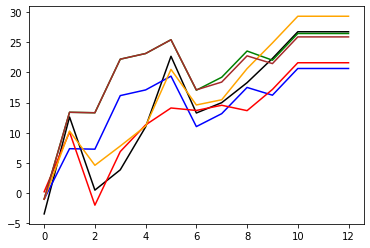

In [489]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['y_buy'], color='blue')
plt.plot(df1['yb_buy'], color='red')
plt.plot(df1['yall_buy'], color='green')
plt.plot(df1['yallb_buy'], color='orange')
plt.plot(df1['yvote_buy'], color='brown')

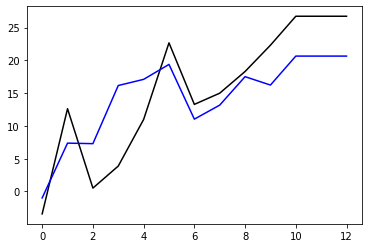

In [490]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['y_buy'], color='blue')


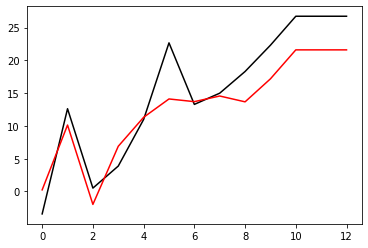

In [491]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yb_buy'], color='red')

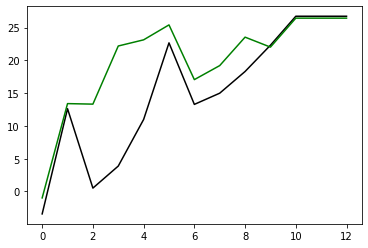

In [492]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yall_buy'], color='green')

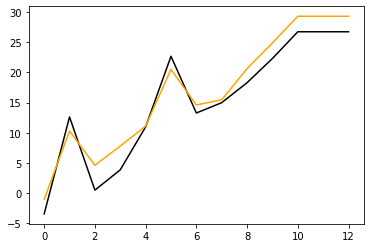

In [493]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yallb_buy'], color='orange')

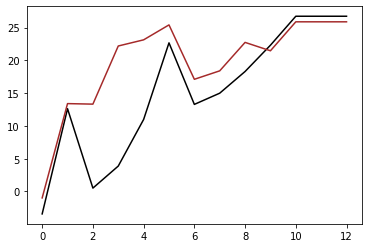

In [494]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yvote_buy'], color='brown')

In [495]:
#results.to_csv('/content/drive/MyDrive/Colab Notebooks/results_sky_hibs_20160101-20210802_.csv')
#performance.to_csv('/content/drive/MyDrive/Colab Notebooks/performance_sky_hibs_20190101-20210802_.csv')